In [1]:
# Step 0: Install and import necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE


Step 1: Load Dataset

In [3]:
# Load dataset
df = pd.read_csv('4) data-project 4.csv')
display(df.head())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Step 2: Explore the Dataset

In [4]:
print(df.shape)
print(df.info())
print(df.describe())

# Check class distribution
print(df['diagnosis'].value_counts())

# Encode target
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})


(569, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se    

Step 3: Handle Missing Values

In [5]:
# Check missing values
print(df.isnull().sum())

# Fill missing numeric values with mean (if any)
df.fillna(df.mean(), inplace=True)


id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

Step 4: Feature Correlation

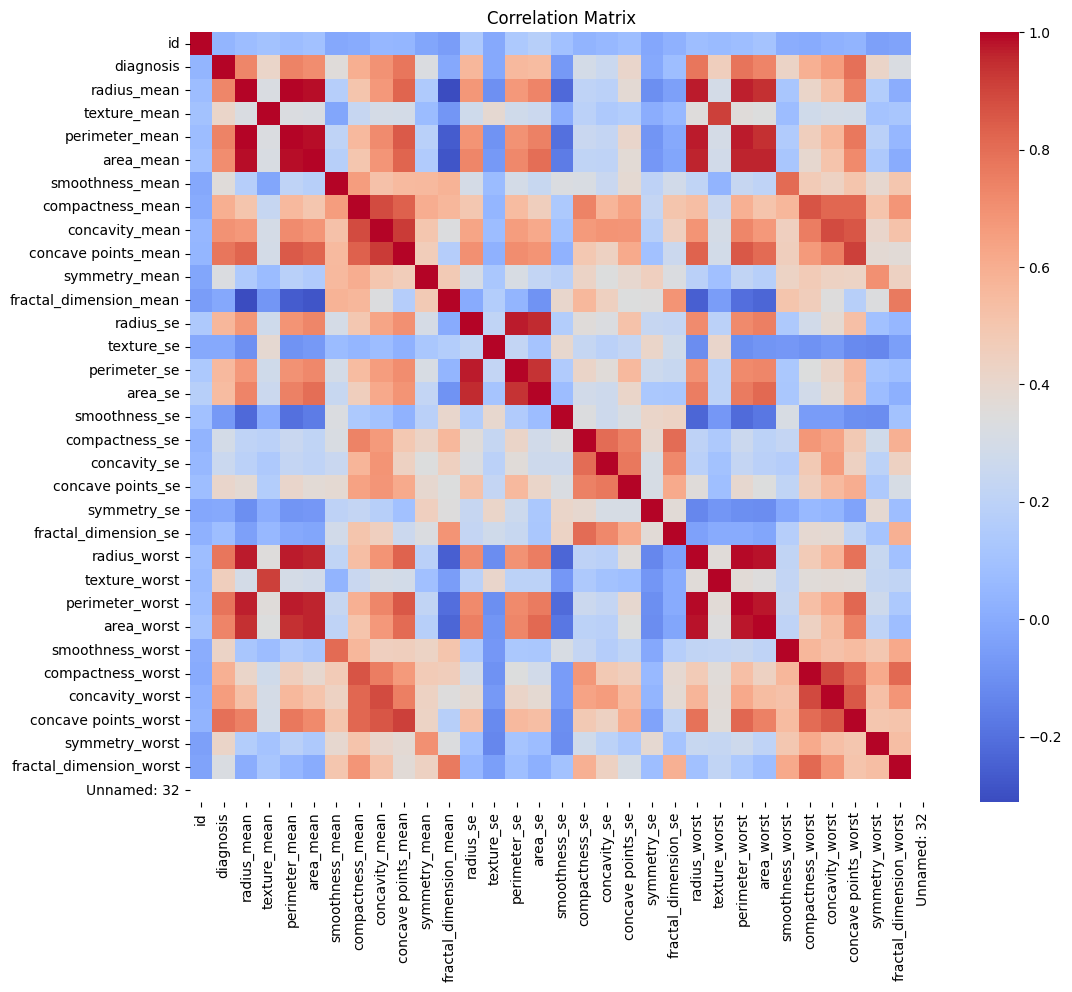

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
id                         0

In [6]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Most predictive features
feature_corr = df.corr()['diagnosis'].sort_values(ascending=False)
print(feature_corr)


Step 5: Define Features and Target

In [7]:
X = df.drop(['diagnosis', 'id'], axis=1, errors='ignore')  # Drop non-feature columns
y = df['diagnosis']


Step 6: Handle Imbalanced Data

In [9]:
# Use SMOTE for balancing
# Drop the 'Unnamed: 32' column as it contains only missing values
X = X.drop('Unnamed: 32', axis=1)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print(pd.Series(y_res).value_counts())

diagnosis
1    357
0    357
Name: count, dtype: int64


Step 7: Split Data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


Step 8: Normalize Features

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Step 9: Train KNN Classifier

In [12]:
# Choose K using cross-validation
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Optimal K: {optimal_k}")

# Train KNN with optimal K
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)


Optimal K: 3


Step 10: Train Logistic Regression

In [13]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]


Step 11: Model Evaluation

In [14]:
def evaluate_model(y_test, y_pred, y_prob=None):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

    if y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob)
        print(f"ROC-AUC: {roc_auc:.3f}")

print("KNN Evaluation:")
evaluate_model(y_test, y_pred_knn)

print("\nLogistic Regression Evaluation:")
evaluate_model(y_test, y_pred_lr, y_prob_lr)


KNN Evaluation:
Accuracy: 0.972, Precision: 0.949, Recall: 1.000, F1: 0.974

Logistic Regression Evaluation:
Accuracy: 0.979, Precision: 0.973, Recall: 0.986, F1: 0.980
ROC-AUC: 0.999


Step 12: Confusion Matrix and ROC Curve

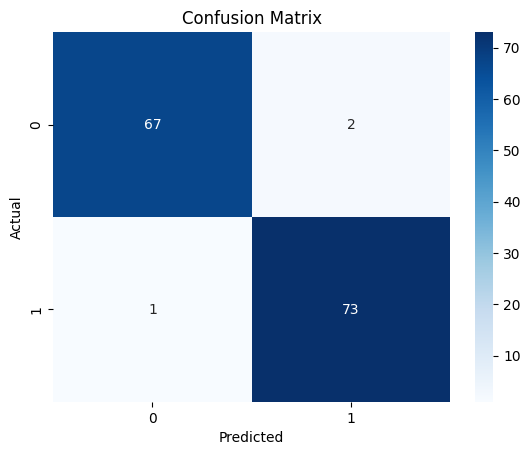

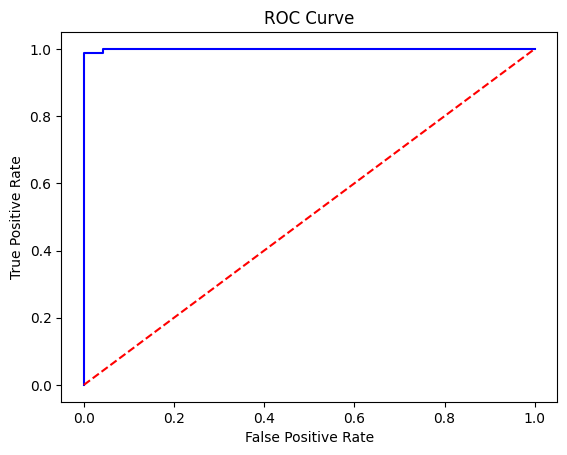

In [15]:
# Confusion matrix for Logistic Regression
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
plt.plot(fpr, tpr, color='blue')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


Step 13: Visualize Decision Boundaries (for 2 features)

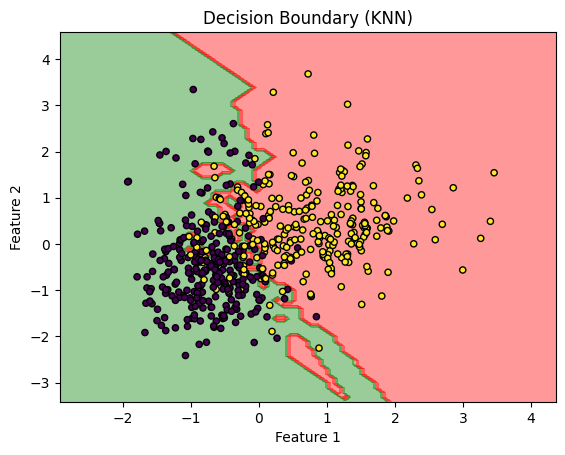

In [16]:
from matplotlib.colors import ListedColormap

# Pick two features for visualization
X_vis = X_train_scaled[:, :2]
y_vis = y_train

knn_vis = KNeighborsClassifier(n_neighbors=optimal_k)
knn_vis.fit(X_vis, y_vis)

# Meshgrid
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(('green','red')))
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_vis, s=20, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary (KNN)')
plt.show()
